# Toxic Comment Classification

The dataset has a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

<list>
<li>toxic
<li>severe_toxic
<li>obscene
<li>threat
<li>insult
<li>identity_hate
</list>

We will require the following libraries:



In [39]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec 
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import SimpleRNN
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import VotingClassifier

from keras.models import Sequential

# Importing the Dataset

In [2]:
df = pd.read_csv('C:/Users/KIIT/OneDrive/Desktop/train.csv')

In [3]:
df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

# Data Wrangling

In [4]:
df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [5]:
df.describe().transpose()

count      mean       std  min  25%  50%  75%  max
toxic          159571.0  0.095844  0.294379  0.0  0.0  0.0  0.0  1.0
severe_toxic   159571.0  0.009996  0.099477  0.0  0.0  0.0  0.0  1.0
obscene        159571.0  0.052948  0.223931  0.0  0.0  0.0  0.0  1.0
threat         159571.0  0.002996  0.054650  0.0  0.0  0.0  0.0  1.0
insult         159571.0  0.049364  0.216627  0.0  0.0  0.0  0.0  1.0
identity_hate  159571.0  0.008805  0.093420  0.0  0.0  0.0  0.0  1.0

In [6]:
df.describe(include=object)

id                                       comment_text
count             159571                                             159571
unique            159571                                             159571
top     0000997932d777bf  Explanation\nWhy the edits made under my usern...
freq                   1                                                  1

# EDA

In [7]:
toxic_counts = df['toxic'].value_counts()
non_toxic_count = toxic_counts[0] if 0 in toxic_counts else 0
toxic_count = toxic_counts[1] if 1 in toxic_counts else 0

#count of each toxicity type for toxic comments
toxicity_types = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxicity_counts = df[df['toxic'] == 1][toxicity_types].sum()

bar_data = pd.DataFrame({
    'Category': ['Toxic', 'Non-Toxic'] + toxicity_types,
    'Count': [toxic_count, non_toxic_count] + list(toxicity_counts)
})

fig = px.bar(bar_data, x='Category', y='Count', color='Category',
             title='Distribution of Toxic and Non-Toxic Comments with Toxicity Types',
             labels={'Count': 'Number of Comments', 'Category': 'Comment Category'})

for i, row in bar_data.iterrows():
    fig.add_annotation(x=row['Category'], y=row['Count']//2, text=str(row['Count']),
                       showarrow=False, font=dict(color='black', size=12))

fig.show()

In [8]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
corr_matrix = pd.DataFrame(index=toxicity_labels, columns=toxicity_labels)
for i in range(len(toxicity_labels)):
    for j in range(i, len(toxicity_labels)):
        corr_matrix.iloc[i, j] = cramers_v(df[toxicity_labels[i]], df[toxicity_labels[j]])
        corr_matrix.iloc[j, i] = corr_matrix.iloc[i, j]

fig = px.imshow(corr_matrix, color_continuous_scale='RdBu',
                labels={'x': 'Attributes', 'y': 'Attributes', 'color': 'Correlation'}, width=800, height=800)
fig.update_layout(title={
    'text': "<b>Cramér\'s V Correlation Heatmap for Toxicity Labels</b>",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top',
})
fig.show()

In [9]:
def avg_word_count(text):
    words = re.findall(r'\w+', text)
    return len(words)

avg_word_counts = df.groupby('toxic')['comment_text'].apply(lambda x: x.apply(avg_word_count).mean()).reset_index()
avg_word_counts['toxic'] = avg_word_counts['toxic'].map({0: 'Non-Toxic', 1: 'Toxic'})

fig = px.bar(avg_word_counts, x='toxic', y='comment_text',
             title='Average Word Count for Toxic and Non-Toxic Comments',
             labels={'comment_text': 'Average Word Count', 'toxic': 'Toxicity Label'})

fig.show()

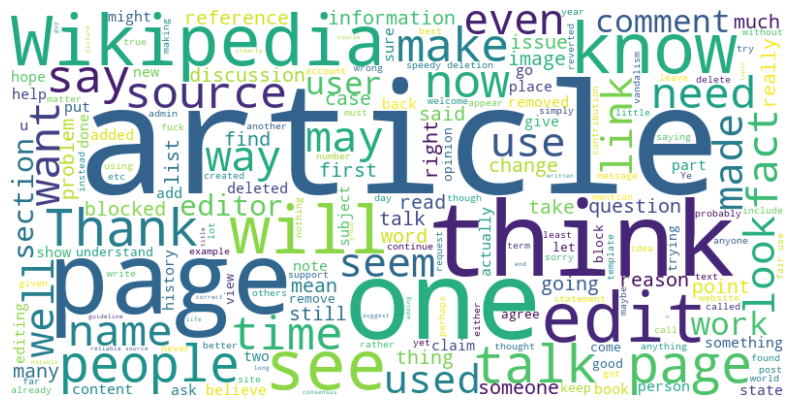

In [10]:
all_comments = ' '.join(df['comment_text'].astype(str))  

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='viridis',  
                      max_words=200,  
                      contour_width=1, contour_color='steelblue').generate(all_comments)

# Setup matplotlib figure
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()


<h1> Data Pre-processing</h1>

In [11]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = df[list_classes].values
list_sentences = df["comment_text"]

In [12]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences))
list_tokenized = tokenizer.texts_to_sequences(list_sentences)

In [13]:
print(tokenizer.word_counts)
tokenizer.word_index

OrderedDict([('explanation', 1771), ('why', 17818), ('the', 496540), ('edits', 9957), ('made', 9678), ('under', 7001), ('my', 45619), ('username', 1823), ('hardcore', 166), ('metallica', 35), ('fan', 1025), ('were', 15421), ('reverted', 3902), ('they', 27318), ("weren't", 424), ('vandalisms', 38), ('just', 27806), ('closure', 88), ('on', 89968), ('some', 22586), ('gas', 331), ('after', 8490), ('i', 204397), ('voted', 302), ('at', 39545), ('new', 10665), ('york', 912), ('dolls', 24), ('fac', 321), ('and', 224192), ('please', 29780), ("don't", 22917), ('remove', 5140), ('template', 3584), ('from', 41511), ('talk', 36420), ('page', 46268), ('since', 8682), ("i'm", 17875), ('retired', 241), ('now', 14732), ('89', 281), ('205', 163), ('38', 425), ('27', 1175), ("d'aww", 1), ('he', 26811), ('matches', 350), ('this', 97586), ('background', 2235), ('colour', 210), ('seemingly', 164), ('stuck', 339), ('with', 59605), ('thanks', 13898), ('21', 1497), ('51', 344), ('january', 1167), ('11', 2104),

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [14]:
list_tokenized[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

In [15]:
X = pad_sequences(list_tokenized, maxlen=200)

<h1> Splitting up the data into Train and Test DataSet</h1>


In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h1>Random Forest</h1>

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy:', accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.8985116716277612

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.06      0.11      3056
           1       0.52      0.03      0.06       321
           2       0.81      0.05      0.10      1715
           3       0.75      0.04      0.08        74
           4       0.79      0.05      0.10      1614
           5       0.50      0.01      0.02       294

   micro avg       0.77      0.05      0.10      7074
   macro avg       0.69      0.04      0.08      7074
weighted avg       0.76      0.05      0.10      7074
 samples avg       0.01      0.00      0.00      7074



C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parame

<h1>LSTM Model</h1>




In [18]:
inp = Input(shape=(200, )) #maxlen=200 as defined earlier

embed_size = 128
x = Embedding(max_features, embed_size)(inp)

x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.1)(x)

x = Dense(50, activation="relu")(x)

x = Dropout(0.1)(x)

x = Dense(6, activation="sigmoid")(x)

model_lstm = Model(inputs=inp, outputs=x)
model_lstm.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 32
epochs = 2
model_lstm.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/2
3591/3591 ━━━━━━━━━━━━━━━━━━━━ 525s 145ms/step - accuracy: 0.8369 - loss: 0.1147 - val_accuracy: 0.9940 - val_loss: 0.0523
Epoch 2/2
3591/3591 ━━━━━━━━━━━━━━━━━━━━ 581s 162ms/step - accuracy: 0.9921 - loss: 0.0466 - val_accuracy: 0.9939 - val_loss: 0.0511


In [19]:
model_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 200, 60)        │        45,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 60)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,826,150 (29.85 MB)

 Trainable params: 2,608,716 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,217,434 (19.90 MB)

In [57]:
# Predict on test set
y_pred = model_lstm.predict(X_test)

# Set threshold value for prediction
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print('Model Accuracy:', accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

998/998 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step
Model Accuracy: 0.920413598621338

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.73      0.79      3056
           1       0.77      0.03      0.06       321
           2       0.82      0.81      0.81      1715
           3       0.00      0.00      0.00        74
           4       0.74      0.68      0.71      1614
           5       0.00      0.00      0.00       294

   micro avg       0.82      0.67      0.74      7074
   macro avg       0.53      0.38      0.40      7074
weighted avg       0.78      0.67      0.71      7074
 samples avg       0.06      0.06      0.06      7074



C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to 

<h1>LightGBM Model</h1>

In [58]:
import lightgbm as LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Convert labels to 1-D numpy array
y_train_flat = y_train[:, 0]  # Assuming binary classification
y_test_flat = y_test[:, 0]

# Convert data into LightGBM dataset format
train_data = LGBMClassifier.Dataset(X_train, label=y_train_flat)
valid_data = LGBMClassifier.Dataset(X_test, label=y_test_flat)

# Parameters for LightGBM
params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'dart',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the model
num_round = 1000
model_lgb = LGBMClassifier.train(params, train_data, num_round, valid_sets=[valid_data])

# Predict on test set
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
y_pred_binary = np.round(y_pred).astype(int)
accuracy = accuracy_score(y_test_flat, y_pred_binary)
print(f'Accuracy: {accuracy}')
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_binary))

Accuracy: 0.9103556321478928

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     28859
           1       0.89      0.07      0.13      3056

    accuracy                           0.91     31915
   macro avg       0.90      0.54      0.54     31915
weighted avg       0.91      0.91      0.87     31915



<h1>Logistic Regression Model</h1>

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Instantiate the logistic regression model
model_lr = LogisticRegression(max_iter=1000)

# Train the model
model_lr.fit(X_train, y_train_flat)

# Predict on validation set
y_pred = model_lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred))

Accuracy: 0.9042769857433809

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     28859
           1       1.00      0.00      0.00      3056

    accuracy                           0.90     31915
   macro avg       0.95      0.50      0.48     31915
weighted avg       0.91      0.90      0.86     31915



<h1>SimpleRNN Model</h1>

In [48]:

# Input layer
inp = Input(shape=(200, )) # maxlen=200 as defined earlier

# Embedding layer
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

# RNN layer
x = SimpleRNN(60, return_sequences=True, name='rnn_layer')(x)

# Global max pooling layer
x = GlobalMaxPool1D()(x)

# Dropout layer
x = Dropout(0.1)(x)

# Dense layer
x = Dense(50, activation="relu")(x)

# Another dropout layer
x = Dropout(0.1)(x)

# Output layer
x = Dense(6, activation="sigmoid")(x)

# Define model
model_rnn = Model(inputs=inp, outputs=x)

# Compile model_rnn
model_rnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 2
model_rnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
3591/3591 ━━━━━━━━━━━━━━━━━━━━ 239s 66ms/step - accuracy: 0.8225 - loss: 0.1100 - val_accuracy: 0.9940 - val_loss: 0.0547
Epoch 2/2
3591/3591 ━━━━━━━━━━━━━━━━━━━━ 297s 83ms/step - accuracy: 0.9817 - loss: 0.0471 - val_accuracy: 0.9939 - val_loss: 0.0519


In [49]:
model_rnn.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer (SimpleRNN)           │ (None, 200, 60)        │        11,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 60)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,724,090 (29.47 MB)

 Trainable params: 2,574,696 (9.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,149,394 (19.64 MB)

In [55]:

# Predict on test set
y_pred = model_rnn.predict(X_test)

# Set threshold value for prediction
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print('Model Accuracy:', accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))


998/998 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step
Model Accuracy: 0.9176249412501958

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3056
           1       0.70      0.08      0.15       321
           2       0.83      0.82      0.82      1715
           3       0.00      0.00      0.00        74
           4       0.71      0.71      0.71      1614
           5       0.00      0.00      0.00       294

   micro avg       0.79      0.70      0.74      7074
   macro avg       0.51      0.40      0.41      7074
weighted avg       0.74      0.70      0.71      7074
 samples avg       0.07      0.07      0.06      7074



C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to 